# Modelagem de T√≥picos com LDA, NMF e SVD
Neste notebook, vamos explorar a modelagem de t√≥picos utilizando tr√™s algoritmos diferentes: Latent Dirichlet Allocation (LDA), Non-negative Matrix Factorization (NMF), e Singular Value Decomposition (SVD). Nosso objetivo √© encontrar o melhor valor de \( k \) (n√∫mero de t√≥picos) para cada um desses algoritmos, utilizando m√©tricas espec√≠ficas a cada um. Por fim, vamos comparar os resultados de cada modelo.


In [6]:
# Libraries
import sys
import os

import warnings
sys.path.append(os.path.abspath('..'))
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import KFold
from scripts.ulteis import preprocess

# Preparar dados 
Por essa parte ser repetitiva n√£o iremos detalhar muito, em resumo aplicamos preprocessamento j√° definido e uma vez que usaremos a biblioteca Gensim teremos que preparar os dados para se adequar ao padr√£o que a biblioteca aceita.

In [7]:
bbc_df = pd.read_csv("../data/bbc_data.csv")

text_df = bbc_df["data"].apply(preprocess)
labels_df = bbc_df["labels"]

# Lista com todas as palavras de todos os textos
texts_topics = [word.split() for word in text_df] 
# Criando um dicion√°rio, associa cada palavra a um id
id2word = corpora.Dictionary(texts_topics)
# Lista de tuplas (id, frequeÃÇncia) para todas as palavras.
corpus = [id2word.doc2bow(text) for text in texts_topics]

# Exemplo
print(corpus[222], "\n")
# Exemplo mapeado
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:222]])

[(4, 2), (39, 1), (40, 2), (67, 2), (70, 1), (85, 4), (90, 2), (95, 1), (106, 1), (112, 2), (119, 1), (133, 1), (138, 2), (142, 4), (143, 3), (148, 1), (153, 4), (161, 4), (168, 1), (175, 4), (178, 11), (185, 1), (194, 1), (233, 1), (244, 1), (246, 1), (250, 1), (258, 1), (272, 1), (276, 1), (281, 1), (282, 2), (289, 1), (296, 1), (299, 3), (304, 1), (319, 1), (327, 1), (334, 1), (343, 1), (348, 1), (352, 1), (363, 1), (371, 1), (377, 1), (384, 4), (386, 1), (387, 1), (388, 3), (398, 1), (399, 2), (400, 2), (401, 2), (402, 2), (408, 1), (424, 1), (426, 1), (427, 2), (430, 1), (431, 2), (436, 1), (437, 4), (441, 1), (478, 1), (483, 1), (509, 2), (512, 1), (514, 1), (524, 1), (600, 1), (623, 1), (632, 2), (634, 1), (674, 2), (723, 1), (736, 1), (749, 5), (776, 1), (830, 1), (848, 1), (859, 1), (893, 1), (894, 1), (909, 1), (922, 1), (923, 1), (928, 1), (934, 1), (957, 1), (959, 1), (993, 5), (994, 1), (995, 5), (996, 3), (1011, 1), (1013, 1), (1034, 1), (1040, 1), (1083, 1), (1099, 1), (

# Modelagem de T√≥picos com LDA

O **Latent Dirichlet Allocation (LDA)** √© um modelo probabil√≠stico que identifica t√≥picos em um conjunto de documentos, assumindo que cada documento √© composto por uma mistura de t√≥picos, e cada t√≥pico √© uma distribui√ß√£o de palavras.

### Coer√™ncia de T√≥picos
Mede a qualidade dos t√≥picos verificando se as palavras dentro de cada t√≥pico fazem sentido juntas. T√≥picos com alta coer√™ncia t√™m palavras semanticamente relacionadas, tornando os t√≥picos mais interpret√°veis.

### Perplexidade
Avalia o qu√£o bem o modelo se ajusta aos dados, com valores mais baixos indicando um melhor ajuste. No entanto, pode n√£o refletir diretamente a qualidade interpret√°vel dos t√≥picos, exigindo um equil√≠brio com a coer√™ncia.


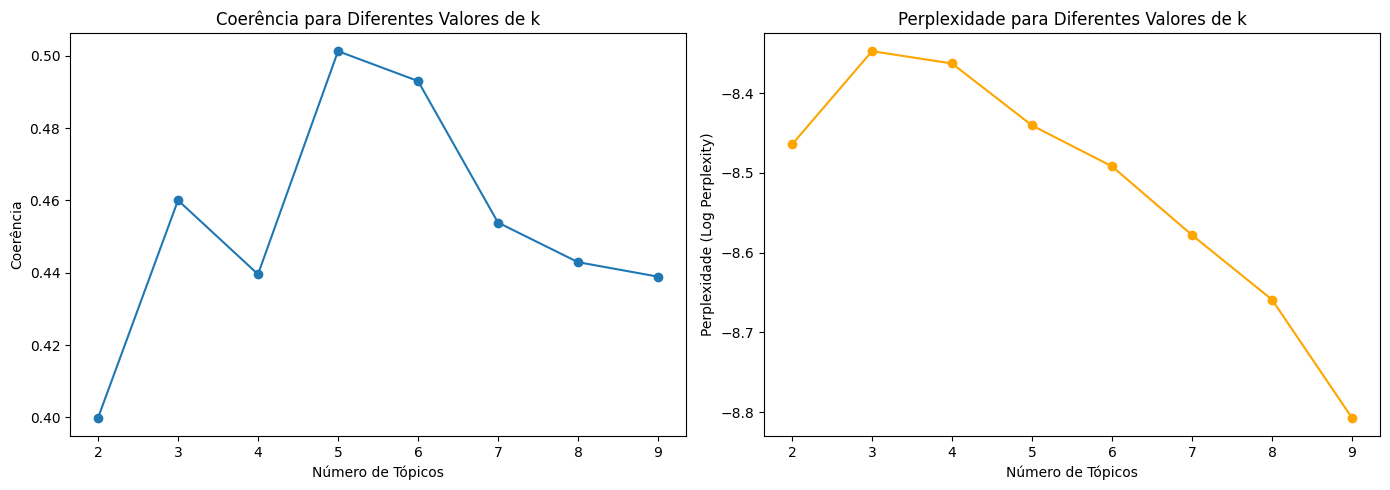

In [8]:
# FuncÃßaÃÉo para treinar o modelo e computar valores de correla√ß√£o e perplexi
def compute_coherence_values(dictionary, corpus, texts, list_range):
    coherence_values = []
    perplexity_values = []
    
    for num_topics in list_range:
        # Treinando o modelo LDA
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, 
                         update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        
        # Calculando a coer√™ncia
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        # Calculando a perplexidade
        perplexity_values.append(model.log_perplexity(corpus))
    
    return coherence_values, perplexity_values


# Plotagem 
list_range = [2,3,4,5,6,7,8,9]
coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts_topics, list_range=list_range)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot coherence values
ax1.plot(list_range, coherence_values, marker='o')
ax1.set_title('Coer√™ncia para Diferentes Valores de k')
ax1.set_xlabel('N√∫mero de T√≥picos')
ax1.set_ylabel('Coer√™ncia')

# Plot perplexity values
ax2.plot(list_range, perplexity_values, marker='o', color='orange')
ax2.set_title('Perplexidade para Diferentes Valores de k')
ax2.set_xlabel('N√∫mero de T√≥picos')
ax2.set_ylabel('Perplexidade (Log Perplexity)')

# Show the plots
plt.tight_layout()
plt.show()

## An√°lise dos Resultados do LDA
Com base no gr√°fico de coer√™ncia, podemos selecionar o valor de \( k \) = 5 que maximiza a coer√™ncia dos t√≥picos. Tamb√©m consideraremos a **perplexidade** para refinar a escolha de \( k \) = 5.


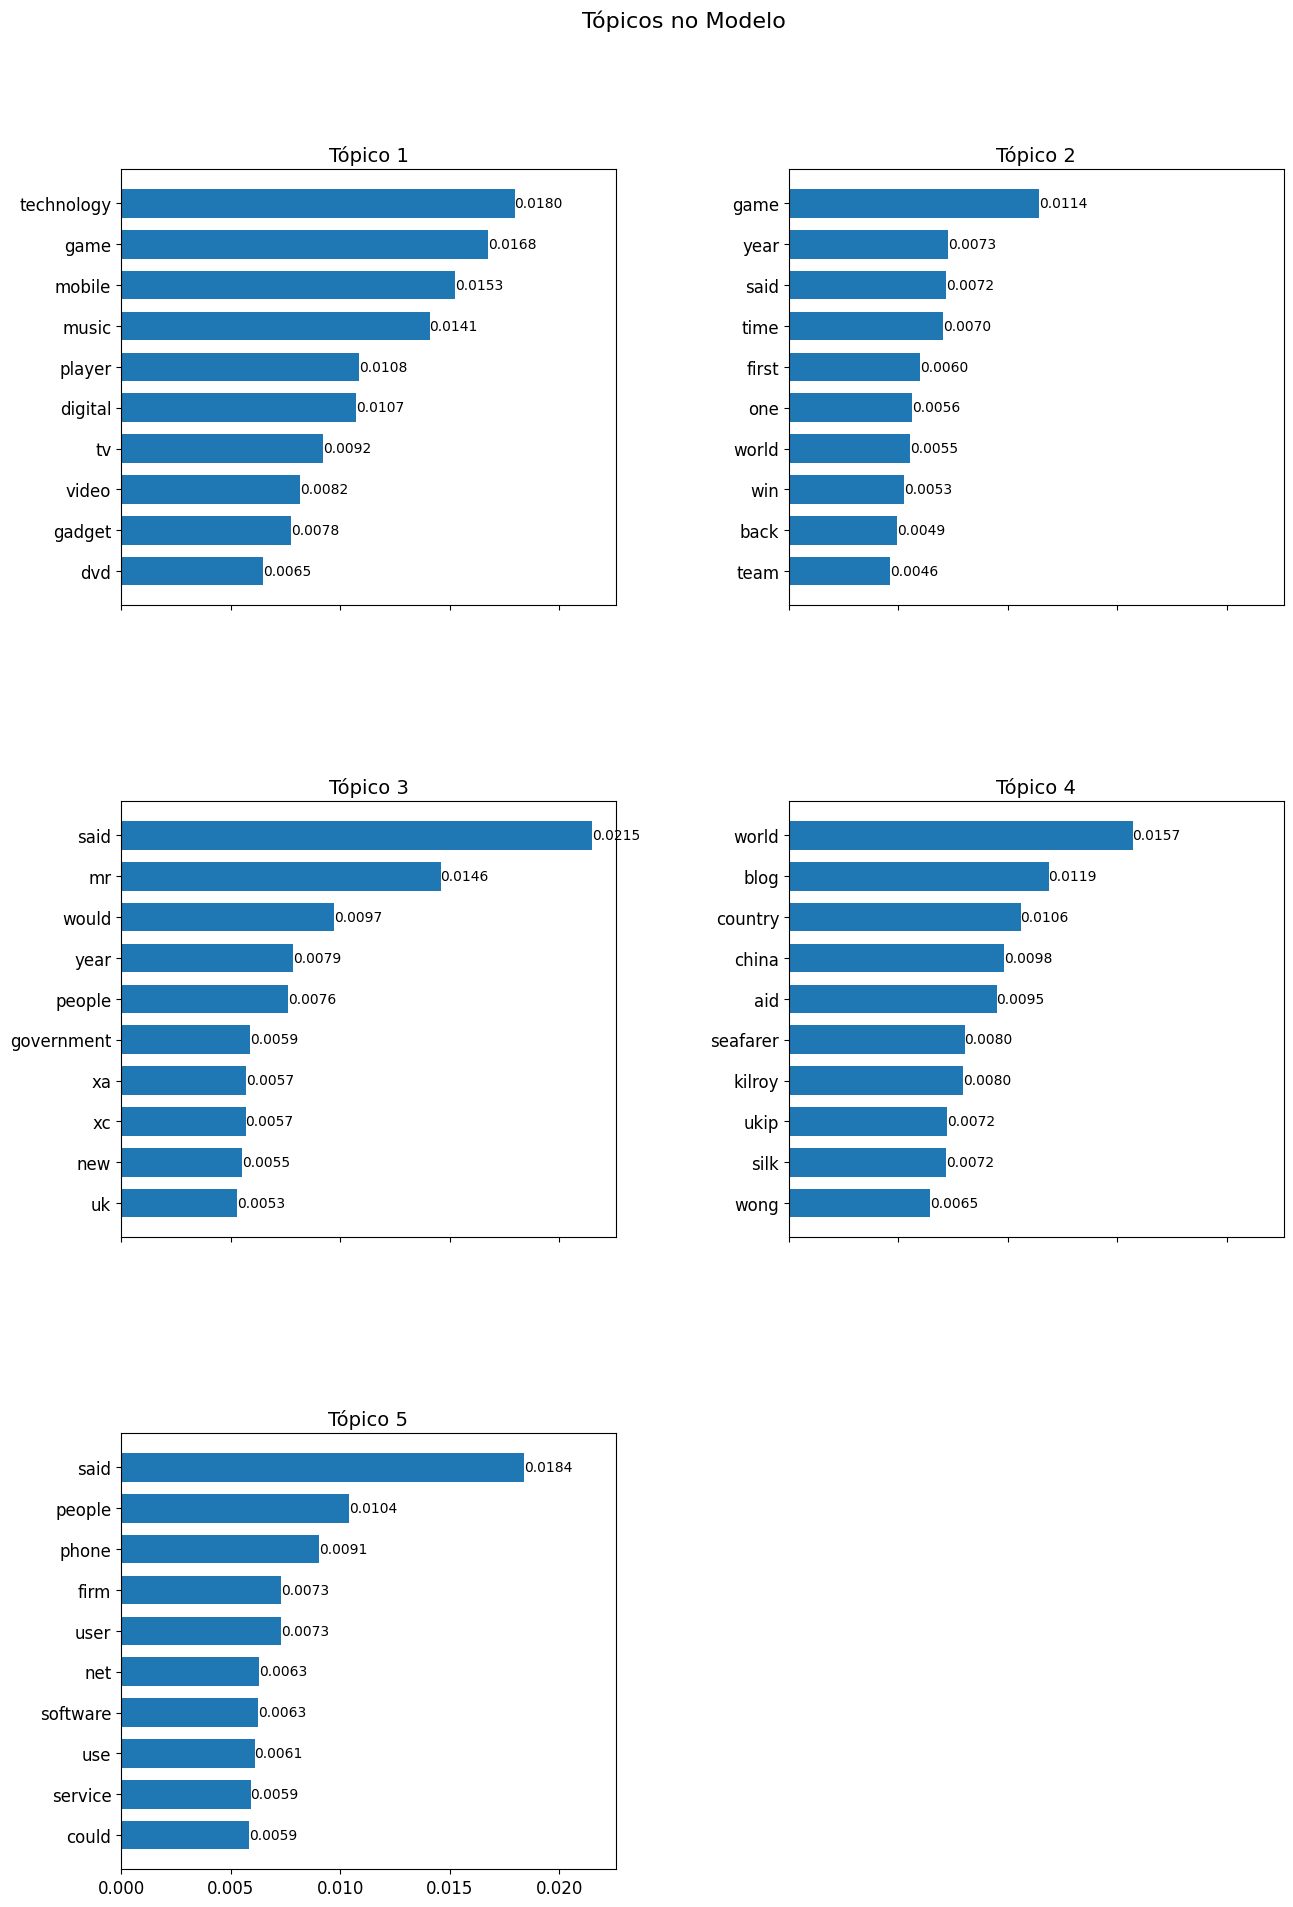

In [9]:
# Fun√ß√£o para exibir as palavras mais relevante de cada topico
def plot_lda_topics(model, num_topics, num_words=10):
    fig, axes = plt.subplots(3, 2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_topics:
            # Obtendo as palavras e os pesos para o t√≥pico
            topic_words = model.show_topic(i, num_words)
            words, weights = zip(*topic_words)
            
            # Criando o gr√°fico de barras horizontais
            ax.barh(words, weights, height=0.7)
            ax.set_title(f'T√≥pico {i+1}', fontsize=14)
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            # Adicionando os valores de pesos nas barras
            for j, (weight, word) in enumerate(zip(weights, words)):
                ax.text(weight, j, f'{weight:.4f}', va='centeF

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.35, hspace=0.45)
    plt.suptitle(f'T√≥picos no Modelo', fontsize=16)
    plt.show()

# Treinando o modelo LDA com k=5
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=100, 
                         update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Plotando os t√≥picos com os pesos
plot_lda_topics(lda, 5)

## An√°lise de cada topico com base nas palavras exibidas

### T√≥pico 1:
- **Palavras-chave**: technology, game, mobile, music, player, digital, tv, video, gadget, dvd
- **Interpreta√ß√£o**: Este t√≥pico parece estar relacionado √† **tecnologia e entretenimento**. As palavras indicam dispositivos m√≥veis, m√∫sica, tecnologia digital e jogos, sugerindo que o t√≥pico cobre temas de tecnologia de consumo.

### T√≥pico 2:
- **Palavras-chave**: game, year, said, time, first, one, world, win, back, team
- **Interpreta√ß√£o**: Este t√≥pico parece estar relacionado a **esportes ou competi√ß√µes**. Palavras como "game", "win", "team" sugerem um foco em competi√ß√µes esportivas ou de jogos, possivelmente eventos anuais ou competi√ß√µes.

### T√≥pico 3:
- **Palavras-chave**: said, mr, would, year, people, government, xa, xc, new, uk
- **Interpreta√ß√£o**: Este t√≥pico parece ter um foco em **not√≠cias pol√≠ticas** ou **governamentais**. Palavras como "government", "mr", "said", "people", "UK" sugerem que o t√≥pico trata de discuss√µes pol√≠ticas ou not√≠cias de governan√ßa.

### T√≥pico 4:
- **Palavras-chave**: world, blog, country, china, aid, seafarer, kilroy, ukip, silk, wong
- **Interpreta√ß√£o**: Este t√≥pico parece abordar **quest√µes globais** ou **rela√ß√µes internacionais**, com palavras como "world", "country", "china", "aid", e "seafarer". Pode estar relacionado a blogs ou discuss√µes sobre pol√≠tica global e com√©rcio.

### T√≥pico 5:
- **Palavras-chave**: said, people, phone, firm, user, net, software, use, service, could
- **Interpreta√ß√£o**: Este t√≥pico provavelmente trata de **tecnologia e telecomunica√ß√µes**. Palavras como "phone", "net", "software", "service" sugerem discuss√µes sobre o uso de dispositivos m√≥veis e servi√ßos de internet.


# Modelagem de T√≥picos com NMF

O **Non-negative Matrix Factorization (NMF)** √© um algoritmo de decomposi√ß√£o matricial que fatoriza a matriz de documentos em duas outras matrizes: uma que representa os t√≥picos e outra que representa a associa√ß√£o entre documentos e t√≥picos. Todos os valores gerados s√£o n√£o-negativos, o que facilita a interpreta√ß√£o dos t√≥picos.

Para validar o melhor n√∫mero de t√≥picos \( k \), vamos utilizar duas m√©tricas principais:

### 1. Sparsidade (Sparsity)
A **sparsidade** mede a quantidade de valores zero nas matrizes resultantes do NMF. Quanto maior a sparsidade, mais esparsa ser√° a matriz, o que significa que cada t√≥pico ser√° composto por poucas palavras e cada documento estar√° associado a poucos t√≥picos.

**Interpreta√ß√£o**: T√≥picos com alta sparsidade s√£o mais facilmente interpret√°veis, pois cada t√≥pico ser√° composto por um n√∫mero reduzido de palavras-chave. Isso facilita a compreens√£o do que o t√≥pico representa.

**Objetivo**: O valor ideal de \( k \) deve maximizar a sparsidade, mantendo os t√≥picos √∫teis e interpret√°veis.

### 2. Erro de Reconstru√ß√£o (Reconstruction Error)
O **erro de reconstru√ß√£o** mede a diferen√ßa entre a matriz original de documentos e a matriz reconstru√≠da a partir dos t√≥picos gerados pelo NMF.

**Interpreta√ß√£o**: Um erro de reconstru√ß√£o menor significa que a decomposi√ß√£o NMF est√° capturando bem as informa√ß√µes presentes na matriz original. No entanto, valores muito baixos de erro podem resultar em overfitting (muitos t√≥picos irrelevantes).

**Objetivo**: O valor de \( k \) ideal deve minimizar o erro de reconstru√ß√£o, garantindo que o modelo capture a estrutura dos dados sem gerar t√≥picos desnecess√°rios.

Ao balancear essas duas m√©tricas, podemos encontrar o n√∫mero \( k \) de t√≥picos que gera a melhor decomposi√ß√£o, com t√≥picos interpret√°veis e uma boa reconstru√ß√£o da matriz original.


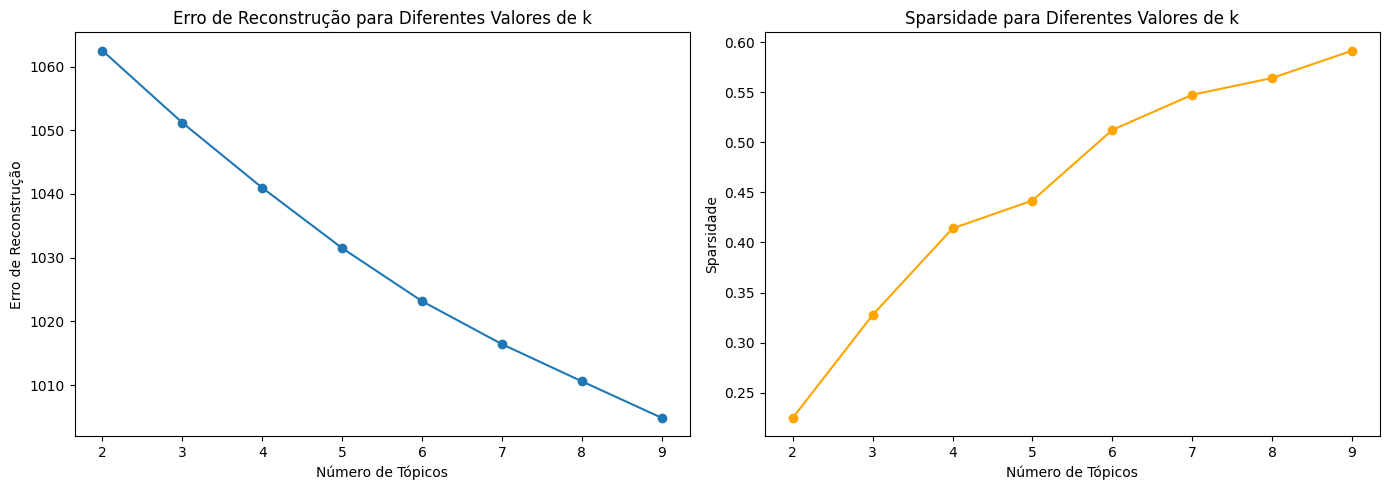

In [10]:
cv = CountVectorizer()
X = cv.fit_transform(text_df)

# Fun√ß√£o para calcular o erro de reconstru√ß√£o e a sparsidade
def compute_nmf_metrics(X, list_range):
    reconstruction_errors = []
    sparsity_values = []
    
    for num_topics in list_range:
        # Treinando o modelo NMF com Scikit-learn
        nmf = NMF(n_components=num_topics, random_state=100, init='nndsvd', max_iter=200)
        W = nmf.fit_transform(X)
        H = nmf.components_
        
        # Calculando o erro de reconstru√ß√£o
        reconstruction_error = np.linalg.norm(X - np.dot(W, H), 'fro')
        reconstruction_errors.append(reconstruction_error)
        
        # Calculando a sparsidade
        sparsity = (np.count_nonzero(W) + np.count_nonzero(H)) / (W.size + H.size)
        sparsity_values.append(1 - sparsity)  # Invertendo para valores maiores representarem maior sparsidade
    
    return reconstruction_errors, sparsity_values

# Lista de valores de k (n√∫mero de t√≥picos)
list_range = [2, 3, 4, 5, 6, 7, 8, 9]

# 2. Calcular os valores de erro de reconstru√ß√£o e sparsidade
reconstruction_errors, sparsity_values = compute_nmf_metrics(X, list_range)

# 3. Plotar os gr√°ficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotar Erro de Reconstru√ß√£o
ax1.plot(list_range, reconstruction_errors, marker='o')
ax1.set_title('Erro de Reconstru√ß√£o para Diferentes Valores de k')
ax1.set_xlabel('N√∫mero de T√≥picos')
ax1.set_ylabel('Erro de Reconstru√ß√£o')

# Plotar Sparsidade
ax2.plot(list_range, sparsity_values, marker='o', color='orange')
ax2.set_title('Sparsidade para Diferentes Valores de k')
ax2.set_xlabel('N√∫mero de T√≥picos')
ax2.set_ylabel('Sparsidade')

# Mostrar os gr√°ficos
plt.tight_layout()
plt.show()

## An√°lise dos Resultados do NMF
Com base nas observa√ß√µes dos gr√°ficos:ùëò = 5 ou ùëò = 6 pode ser um bom valor para o n√∫mero de t√≥picos. Isso ocorre porque, a partir desses valores, a redu√ß√£o no erro de reconstru√ß√£o come√ßa a se estabilizar, e a sparsidade aumenta a um n√≠vel que ainda permite uma boa interpretabilidade dos t√≥picos.


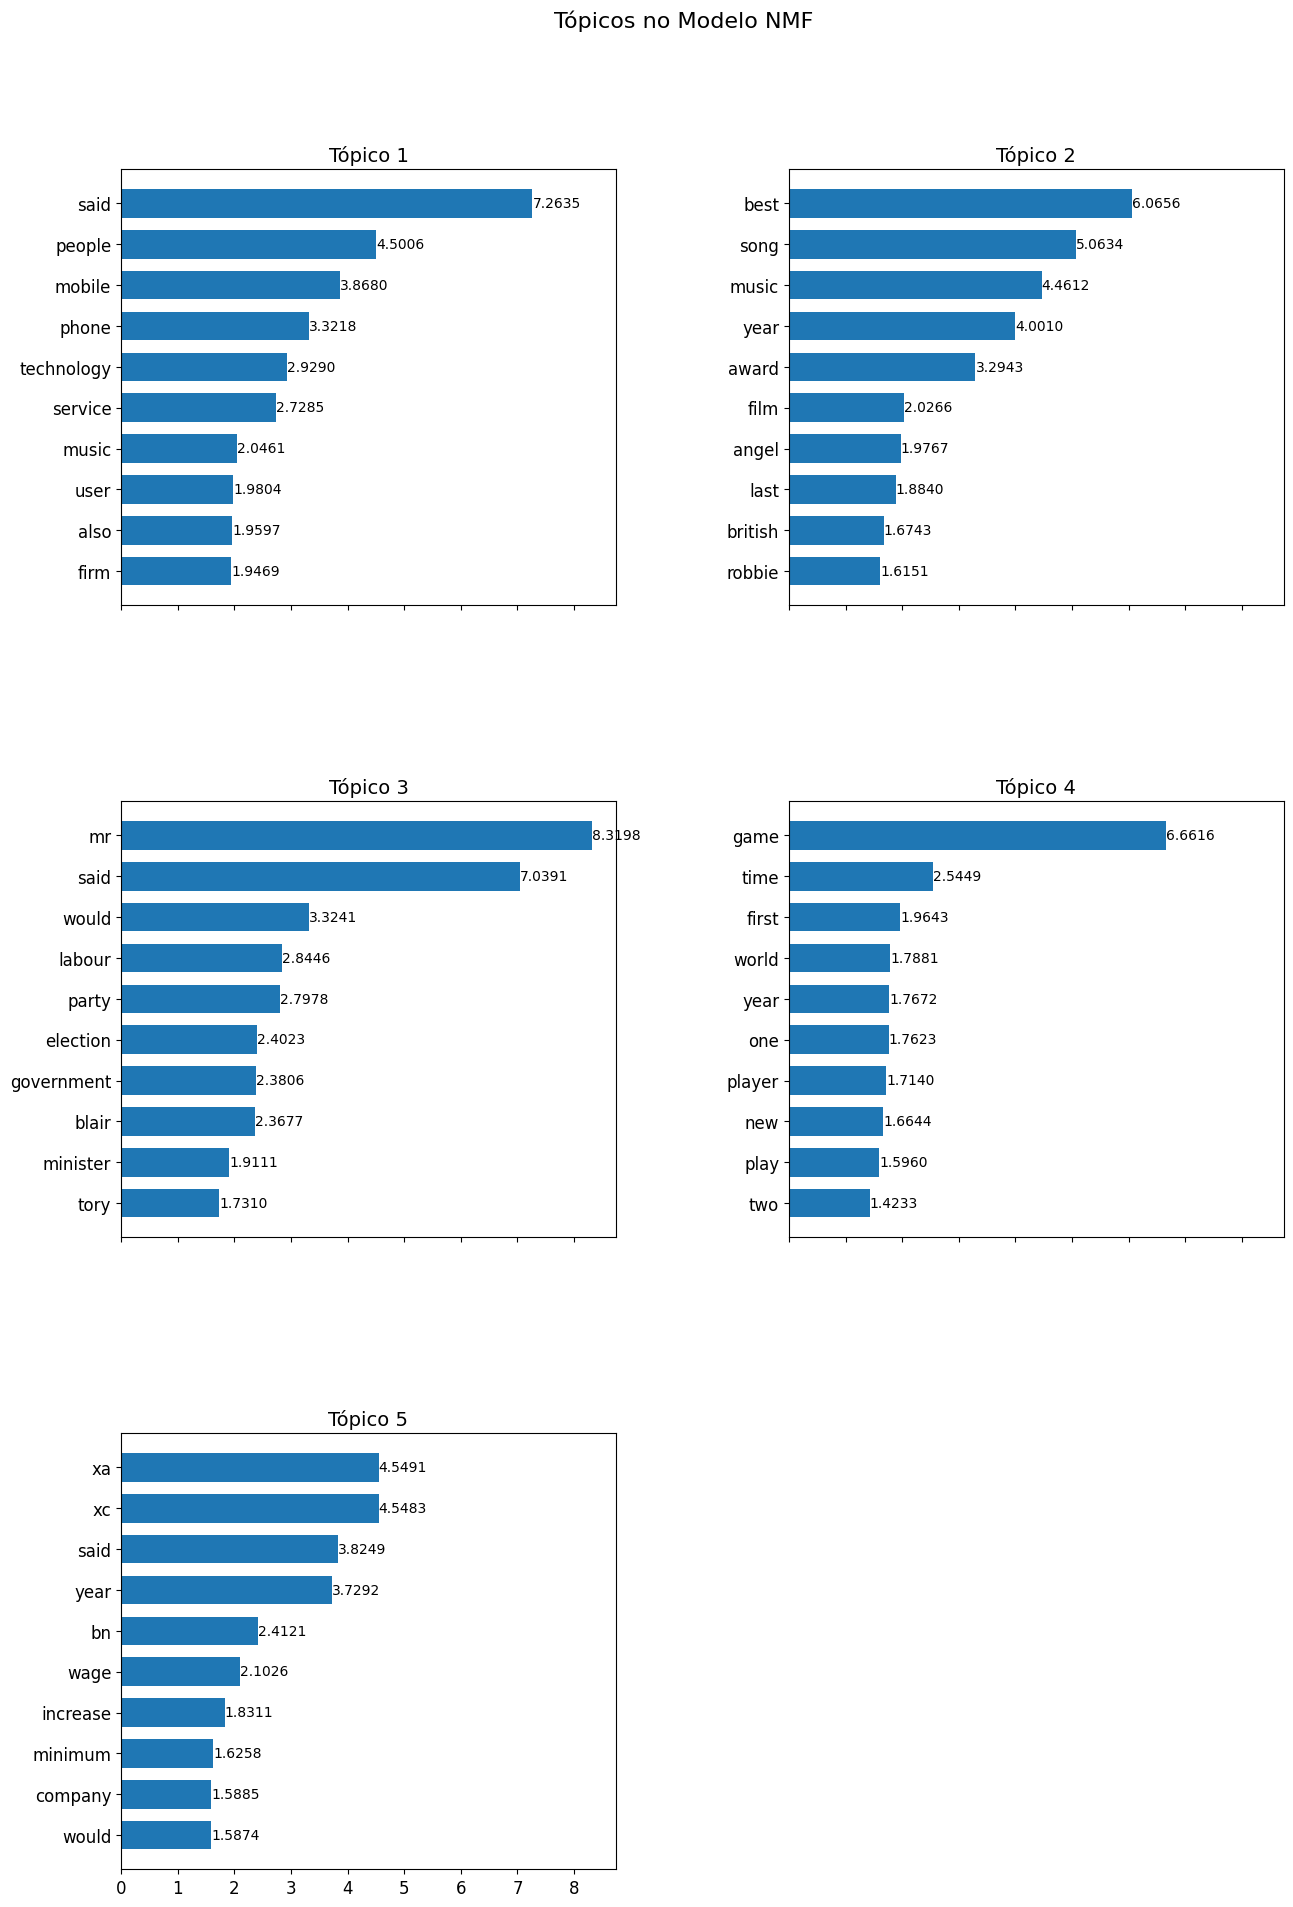

In [11]:
# Fun√ß√£o para exibir os t√≥picos
def plot_nmf_topics(model, feature_names, num_words=10):
    num_topics = model.components_.shape[0]
    fig, axes = plt.subplots(3, 2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_topics:
            # Obtendo os √≠ndices das palavras mais importantes para cada t√≥pico
            top_words_idx = model.components_[i].argsort()[-num_words:][::-1]
            top_words = [feature_names[idx] for idx in top_words_idx]
            top_weights = model.components_[i][top_words_idx]

            # Plotando os t√≥picos
            ax.barh(top_words, top_weights, height=0.7)
            ax.set_title(f'T√≥pico {i+1}', fontsize=14)
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            # Adicionando os valores de pesos nas barras
            for j, (weight, word) in enumerate(zip(top_weights, top_words)):
                ax.text(weight, j, f'{weight:.4f}', va='center')  # Mostrando os pesos com 4 casas decimais
        else:
            ax.axis('off')

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.35, hspace=0.45)
    plt.suptitle(f'T√≥picos no Modelo NMF', fontsize=16)
    plt.show()

# Chamando a fun√ß√£o para plotar os t√≥picos
feature_names = cv.get_feature_names_out()  # Obtendo os nomes das palavras do CountVectorizer ou TfidfVectorizer
nmf = NMF(n_components=5, random_state=100, init='nndsvd', max_iter=200)
nmf.fit_transform(X)
plot_nmf_topics(nmf, feature_names, num_words=10)


# Modelagem de T√≥picos com SVD
O **Singular Value Decomposition (SVD)** √© uma t√©cnica de fatora√ß√£o matricial. Vamos utilizar a **vari√¢ncia explicada** e **Erro de reconstru√ß√£o** para definir o n√∫mero ideal de componentes \( k \).


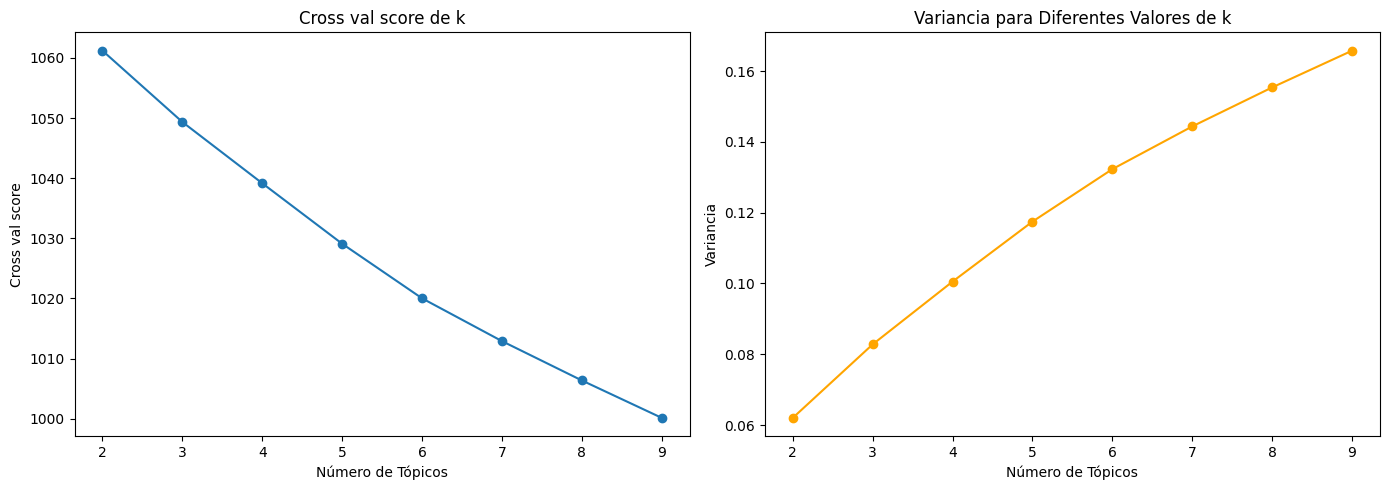

In [13]:
# Fun√ß√£o para calcular o erro de reconstru√ß√£o e a sparsidade
def compute_svd_metrics(X, list_range):
    reconstruction_errors = []
    variance_scores = []
    
    # K-fold
    kf = KFold(shuffle=True)
    
    for i in list_range:
        svd = TruncatedSVD(n_components=i)
        X_transformed = svd.fit_transform(X)
        
        # Calculando a vari√¢ncia explicada (soma das vari√¢ncias explicadas de todas as componentes)
        variance_explained = np.sum(svd.explained_variance_ratio_)
        variance_scores.append(variance_explained)
        
        # Calculando o erro de reconstru√ß√£o (reprojetando o dado original)
        X_reconstructed = np.dot(X_transformed, svd.components_)
        reconstruction_error = np.linalg.norm(X - X_reconstructed, 'fro')
        reconstruction_errors.append(reconstruction_error)
    
    return reconstruction_errors, variance_scores

# Lista de valores de k (n√∫mero de t√≥picos)
list_range = [2, 3, 4, 5, 6, 7, 8, 9]

# 2. Calcular os valores de variancia e cross val score
reconstruction_errors, variance_scores = compute_svd_metrics(X, list_range)

# 3. Plotar os gr√°ficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotar cross val score 
ax1.plot(list_range, reconstruction_errors, marker='o')
ax1.set_title('Cross val score de k')
ax1.set_xlabel('N√∫mero de T√≥picos')
ax1.set_ylabel('Cross val score')

# Plotar Sparsidade
ax2.plot(list_range, variance_scores, marker='o', color='orange')
ax2.set_title('Variancia para Diferentes Valores de k')
ax2.set_xlabel('N√∫mero de T√≥picos')
ax2.set_ylabel('Variancia')

# Mostrar os gr√°ficos
plt.tight_layout()
plt.show()

## An√°lise dos Resultados do SVD
Os graficos obtidos acima n√£o nos ajudam muito a definir o melhor valor de K, visto que aparent√£o ser bastante uniformes, mas para seguir a analise vamos tomar k = 5.

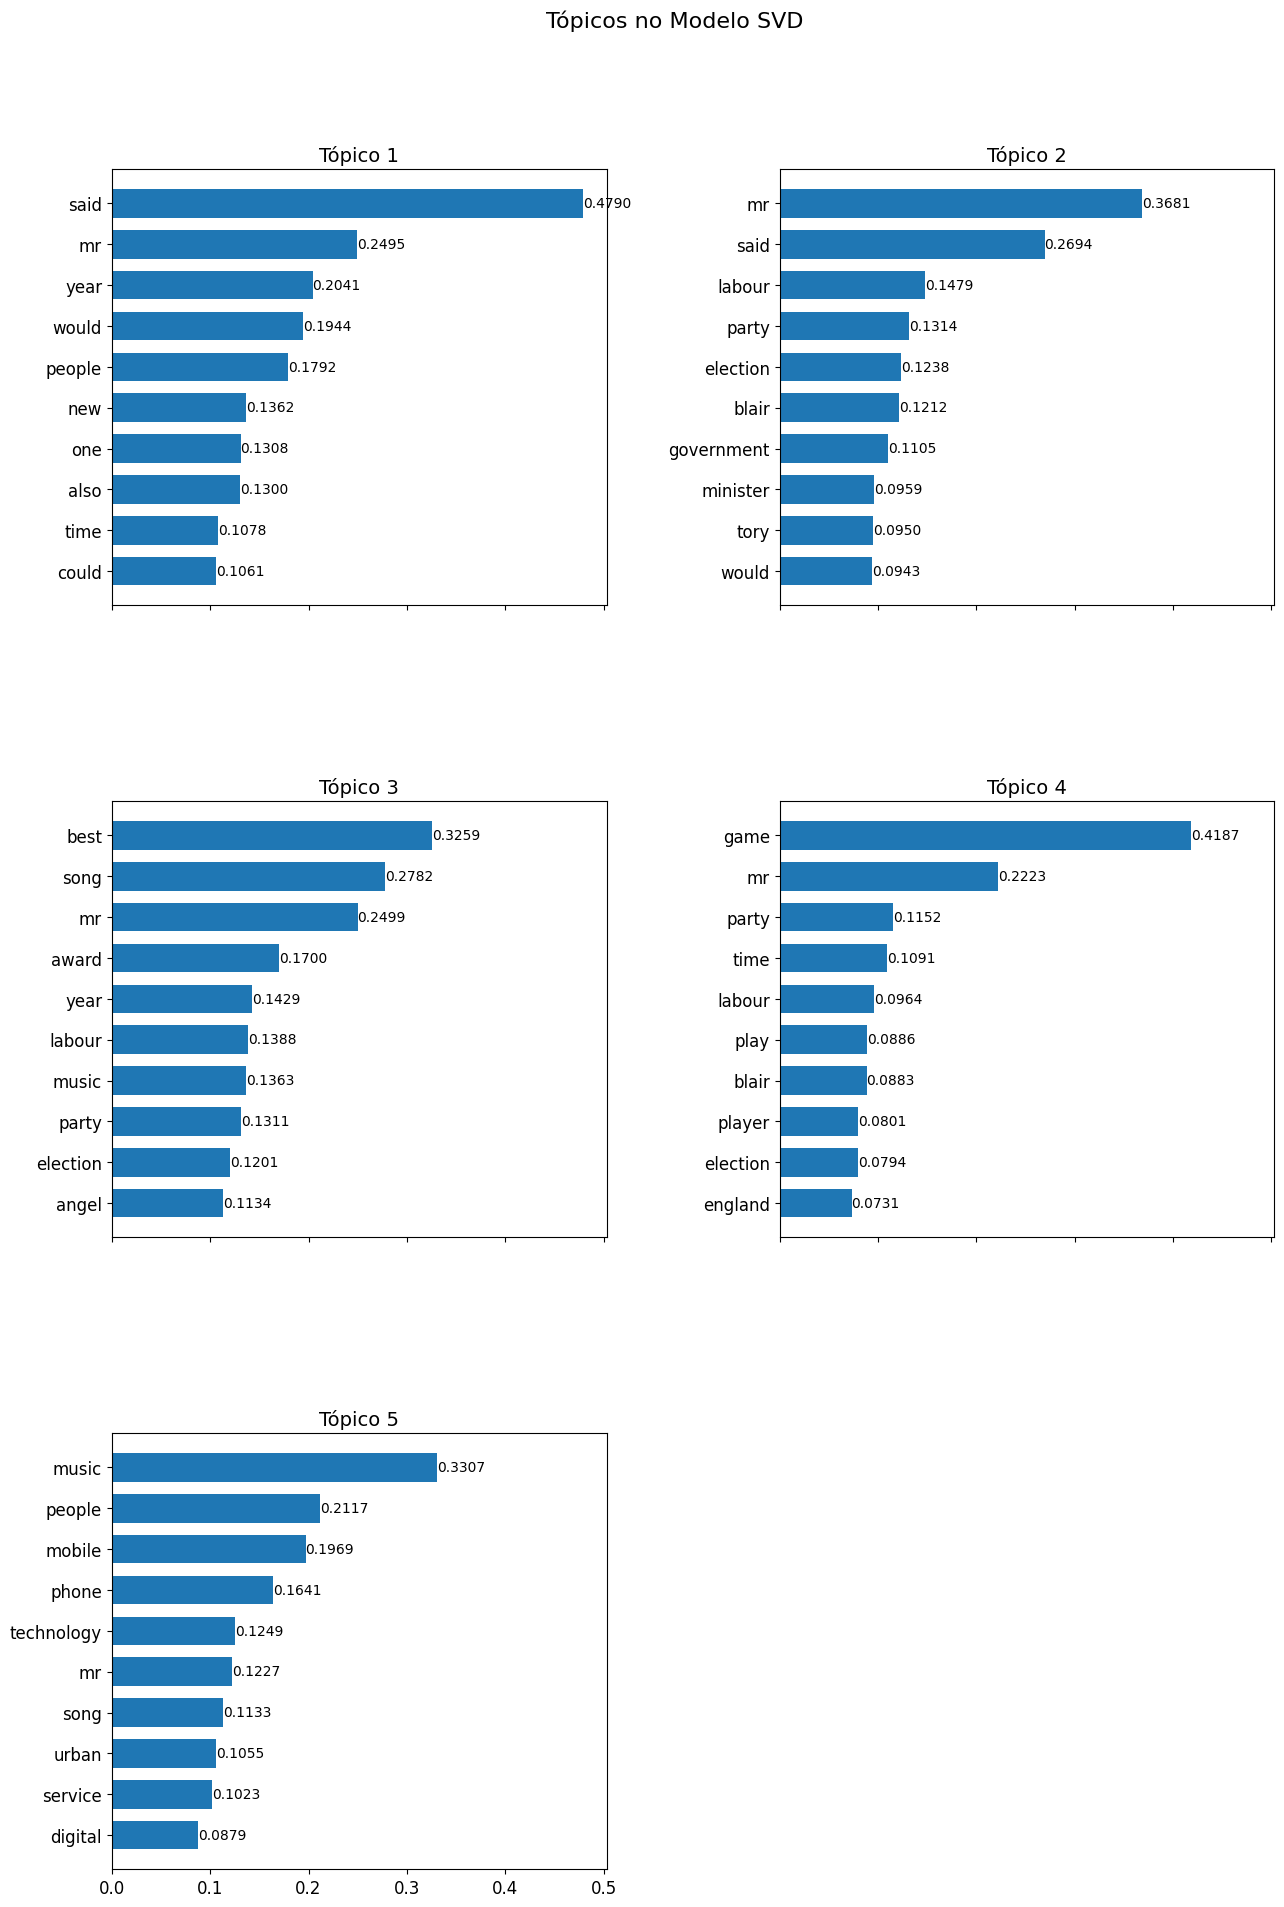

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Fun√ß√£o para exibir os t√≥picos do SVD
def plot_svd_topics(model, feature_names, num_words=10):
    num_topics = model.components_.shape[0]
    fig, axes = plt.subplots(3, 2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_topics:
            # Obtendo os √≠ndices das palavras mais importantes para cada componente/t√≥pico
            top_words_idx = model.components_[i].argsort()[-num_words:][::-1]
            top_words = [feature_names[idx] for idx in top_words_idx]
            top_weights = model.components_[i][top_words_idx]

            # Plotando os t√≥picos
            ax.barh(top_words, top_weights, height=0.7)
            ax.set_title(f'T√≥pico {i+1}', fontsize=14)
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)

            # Adicionando os valores de pesos nas barras
            for j, (weight, word) in enumerate(zip(top_weights, top_words)):
                ax.text(weight, j, f'{weight:.4f}', va='center')  # Mostrando os pesos com 4 casas decimais
        else:
            ax.axis('off')

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.35, hspace=0.45)
    plt.suptitle(f'T√≥picos no Modelo SVD', fontsize=16)
    plt.show()

# Chamando a fun√ß√£o para plotar os t√≥picos
feature_names = cv.get_feature_names_out()  # Obtendo os nomes das palavras do CountVectorizer ou TfidfVectorizer
svd = TruncatedSVD(n_components=5, random_state=100)
svd.fit_transform(X)
plot_svd_topics(svd, feature_names, num_words=10)


## An√°lise de cada topico com base nas palavras exibidas

### T√≥pico 1:
- **Palavras-chave**: said, mr, year, would, people, new, one, also, time, could
- **Interpreta√ß√£o**: O t√≥pico est√° relacionado a **not√≠cias ou declara√ß√µes p√∫blicas**, focando em figuras proeminentes e eventos ao longo do tempo. H√° men√ß√µes frequentes a pessoas, anos e possibilidades, indicando discuss√µes sobre **mudan√ßas sociais ou pol√≠ticas**.

### T√≥pico 2:
- **Palavras-chave**: mr, said, labour, party, election, blair, government, minister, tory, would
- **Interpreta√ß√£o**: Claramente relacionado √† **pol√≠tica no Reino Unido**, mencionando o **Partido Trabalhista**, o **Partido Conservador** e figuras pol√≠ticas como **Tony Blair**. O foco est√° em **discuss√µes eleitorais e governamentais**.

### T√≥pico 3:
- **Palavras-chave**: best, song, music, year, award, labour, party, election, angel
- **Interpreta√ß√£o**: Combina **entretenimento e pol√≠tica**, com foco em **premia√ß√µes e a ind√∫stria musical**, al√©m de refer√™ncias a **debates eleitorais** e eventos culturais com relev√¢ncia pol√≠tica.

### T√≥pico 4:
- **Palavras-chave**: game, mr, party, time, labour, play, blair, player, election, england
- **Interpreta√ß√£o**: Mistura temas de **jogos e pol√≠tica**, com refer√™ncias a competi√ß√µes e discuss√µes pol√≠ticas brit√¢nicas. Possivelmente trata de **eventos esportivos com impacto pol√≠tico**.

### T√≥pico 5:
- **Palavras-chave**: music, people, mobile, phone, technology, mr, song, urban, service, digital
- **Interpreta√ß√£o**: Foca em **tecnologia e telecomunica√ß√µes**, incluindo o impacto de dispositivos m√≥veis e servi√ßos digitais, com men√ß√µes √† **m√∫sica** e **servi√ßos urbanos**.


# Compara√ß√£o Final e Conclus√£o
Ap√≥s a modelagem de t√≥picos utilizando os algoritmos **LDA**, **NM** e **SVD**, observamos que o **LDA** (Latent Dirichlet Allocation) destacou-se significativamente no quesito de sem√¢ntica dos t√≥picos. O **LDA** mostrou uma maior coer√™ncia entre as palavras dentro de cada t√≥pico, sugerindo agrupamentos de termos que fazem mais sentido juntos e facilitando a interpreta√ß√£o dos temas extra√≠dos dos dados.

